# Image Classification using Logistic Regression and K-Means  
## Fashion-MNIST Dataset (5 Classes)

This project applies **Logistic Regression** (supervised learning) and **K-Means clustering** (unsupervised learning) as classifiers on an image dataset.  
Feature extraction is performed using **Histogram of Oriented Gradients (HOG)**, followed by **feature scaling** and **dimensionality reduction using PCA**.

The goal is to evaluate and compare both models on a subset of the Fashion-MNIST dataset consisting of five image classes.
:

#**Import needed Lib**

In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import mode
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, auc
)
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

**Load dataset**

In [2]:
fashion_mnist=fetch_openml(data_id=40996,cache=True)
print(fashion_mnist.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


## Load Fashion-MNIST Dataset

The Fashion-MNIST dataset is loaded using `fetch_openml`.  
It contains grayscale images of fashion items, each image represented as a flattened vector of 784 pixels (28×28).

Each sample belongs to one of 10 possible classes.


In [3]:
# read dataset in dataframe
df=fashion_mnist['frame']

In [4]:
df.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
1,0,0,0,0,0,1,0,0,0,0,...,114,130,76,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,22,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,33,96,...,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Dataset Structure Overview

- Each row represents one image.
- Pixel values range from 0 to 255.
- The dataset contains:
  - 784 pixel columns
  - 1 class label column


In [5]:
X =fashion_mnist['data']
y = fashion_mnist['target'].astype(str)

In [6]:
# check the size of data
df.shape

(70000, 785)

In [7]:
# rename the labels output
classes=['t-shirt','trouser','pullover','dress','coat','sandal','shirt','sneakers','bag','ankle boat']

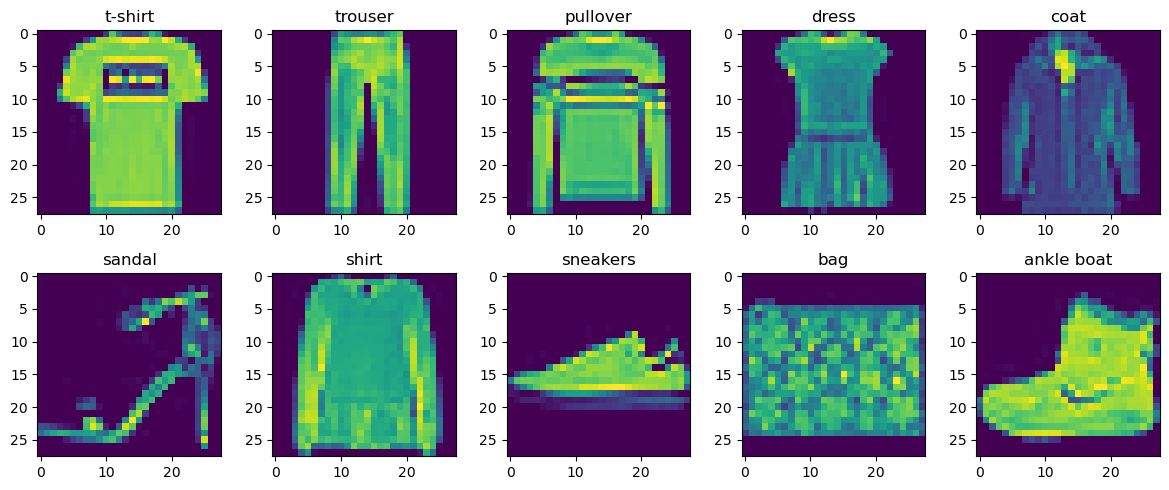

In [8]:
## represent sample of data
class_indices=y.unique()
class_indices=list(class_indices)
class_indices.sort()
class_indices


plt.rcParams['figure.figsize']=(12,5)
plt.rcParams['figure.dpi']=100
for i in class_indices:
  plt.subplot(2,5,int(i)+1)
  # Filter X for images of class i, take the first one, convert to numpy, and reshape
  img = X[y == i].iloc[0].to_numpy().reshape(28,28)
  plt.imshow(img)
  plt.title(classes[int(i)])
  plt.tight_layout()

## Sample Visualization from Dataset

This cell visualizes one example image from each class by reshaping the flattened pixel vector into a 28×28 grayscale image.  
This helps verify the correctness of data loading and understand the visual differences between classes.


In [9]:
# check the data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 785 entries, pixel1 to class
dtypes: category(1), int64(784)
memory usage: 418.8 MB


**Total samples: 70,000 images**



*   Number of columns: 785
*   784 columns (pixel1 to pixel784) represent the grayscale pixel values of each 28×28 image.



*   column (class) represents the label/category of the image.


**Data types:**



*   Pixel columns are stored as int64.
*  Labels are stored as category.





In [10]:
#check duplicated records
df.duplicated().sum()

np.int64(0)

In [11]:
#check for missing values
df.isnull().sum()

pixel1      0
pixel2      0
pixel3      0
pixel4      0
pixel5      0
           ..
pixel781    0
pixel782    0
pixel783    0
pixel784    0
class       0
Length: 785, dtype: int64

C:\Users\omara\AppData\Local\Temp\ipykernel_1836\163181772.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby('class').count()['pixel1']


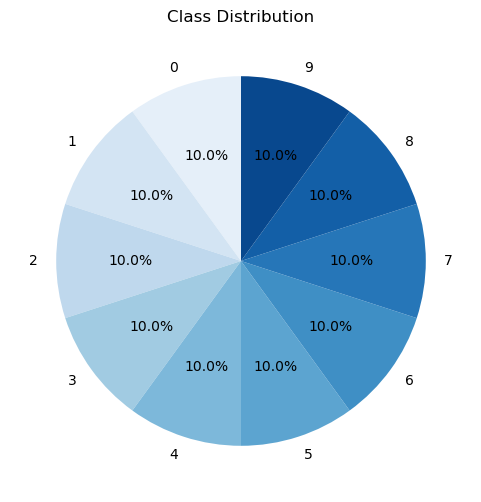

In [12]:
#check if ther imbalance in target col
colors = sns.color_palette("Blues", n_colors=len(df['class'].unique()))

# Prepare data
counts = df.groupby('class').count()['pixel1']
labels = counts.index

# Plot
plt.figure(figsize=(6,6))
plt.pie(
    x=counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)

plt.title("Class Distribution")
plt.show()

No class imbalance exists in the original Fashion MNIST dataset.

## Class Distribution Analysis

A pie chart is used to visualize the distribution of classes in the dataset.  
Fashion-MNIST is a balanced dataset, meaning each class contains approximately the same number of samples.


##**Select only 5**

## Selecting a Subset of 5 Classes

For this project, only five classes are selected to meet the project requirements:
- T-shirt/top
- Trouser
- Pullover
- Dress
- Coat

This reduces model complexity while maintaining meaningful classification tasks.


In [13]:
y = fashion_mnist['target'].astype(int)


In [14]:
selected_classes = [0, 1, 2, 3, 4]
mask = y.isin(selected_classes)

X_5 = X[mask]
y_5 = y[mask]


In [15]:

# Map numeric labels to meaningful class names
classes_5 = ['t-shirt','trouser','pullover','dress','coat']


In [16]:
df_5 = df[df['class'].astype(int).isin(selected_classes)].reset_index(drop=True)
df_5['class'] = df_5['class'].astype(int)


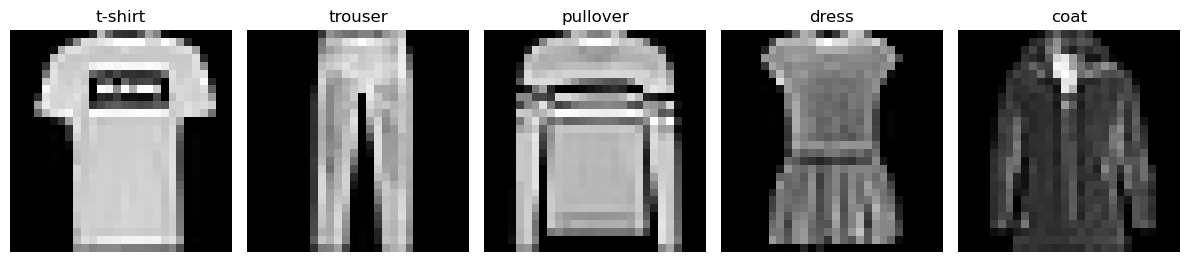

In [17]:
plt.figure(figsize=(12, 5))

# Unique integer classes
unique_classes = sorted(df_5['class'].unique())

for i, cls in enumerate(unique_classes):
    plt.subplot(1, 5, i + 1)

    # Get the POSITION (0...N) of the first image with class cls
    pos = df_5.index[df_5['class'] == cls][0]

    # Use iloc, NOT loc (avoids KeyError)
    img = X_5.iloc[pos].to_numpy().reshape(28, 28)

    plt.imshow(img, cmap='gray')
    plt.title(classes_5[cls])
    plt.axis('off')

plt.tight_layout()
plt.show()

#**Data Preprocessing**

##Feature Exteraction

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X_5, y_5, test_size=0.2, random_state=42, stratify=y_5
)


## Train-Test Split

The dataset is split into:
- 80% training data
- 20% testing data

Stratified splitting is used to preserve class distribution across both sets.


In [19]:
# 2. Define HOG extraction function
def extract_hog_features(X_array):
    feats = []
    for i in range(len(X_array)):
        img = X_array.iloc[i].to_numpy().reshape(28,28)
        f = hog(img, orientations=9, pixels_per_cell=(4,4),
                cells_per_block=(2,2), block_norm="L2-Hys")
        feats.append(f)
    return np.array(feats)

# 3. Compute HOG features separately
X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

## Feature Extraction using Histogram of Oriented Gradients (HOG)

HOG is applied to each image to extract edge and shape-based features.  
Each 28×28 image is converted into a feature vector of length 1296.

HOG improves robustness against illumination changes and captures spatial structure effectively.


#Normalization (Feature Scaling)

## Feature Scaling

Standardization is applied to HOG features to ensure that all features have zero mean and unit variance.  
This step is critical for distance-based algorithms such as K-Means and for faster convergence in Logistic Regression.


In [ ]:
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled  = scaler.transform(X_test)

In [20]:
#  Fit scaler on training HOG features
scaler = StandardScaler()
X_train_hog_scaled = scaler.fit_transform(X_train_hog)

#  Transform test HOG features with the same scaler
X_test_hog_scaled = scaler.transform(X_test_hog)

After scaling, all features are on a similar scale, which ensures fair weighting in model training.

#Dimensionality Reduction Using PCA

## Dimensionality Reduction using PCA

Principal Component Analysis (PCA) is used to reduce feature dimensionality while preserving 95% of the total variance.

This reduces computational cost and minimizes redundancy in HOG features.


In [21]:
pca = PCA(n_components=0.95, svd_solver='full')
X_train_pca = pca.fit_transform(X_train_hog_scaled)
X_test_pca  = pca.transform(X_test_hog_scaled)
print("After PCA dim:", X_train_pca.shape[1])

After PCA dim: 383


In [23]:
print("X_train_pca shape:", X_train_pca.shape)
print("X_test_pca shape:", X_test_pca.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train_pca shape: (28000, 383)
X_test_pca shape: (7000, 383)
y_train shape: (28000,)
y_test shape: (7000,)


as HOG features produce high-dimensional data (1296 features per image).
so PCA Keeps only the components that explain 95% of the total variance.
Most of the important information from the original HOG features is retained, while noise and redundancy are reduced.

#**Model Building**

The dataset is split into 80% training and 20% testing, which is standard practice.

stratify=y_5 ensures each class appears in the same proportion in both sets.

Test set is kept separate for final evaluation, not used in training or hyperparameter tuning.

#Model Training and Hyperparameter Tuning

##Kmean

## K-Means Clustering as a Classifier

K-Means clustering is applied with K equal to the number of classes (K=5).  
Clusters are mapped to class labels using majority voting (mode).

Although K-Means is unsupervised, this approach allows it to be evaluated as a classifier.


In [24]:
# Fit K-Means
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters_train = kmeans.fit_predict(X_train_pca)


In [25]:
# Map clusters to labels
def map_clusters_to_labels(clusters, y_true):
    labels = np.zeros_like(clusters)
    for c in np.unique(clusters):
        mask = clusters == c
        # Get the subset of true labels for this cluster
        subset_y_true = y_true.iloc[mask]

        if not subset_y_true.empty:
            # Calculate mode using pandas value_counts and idxmax
            # This is more robust as .idxmax() directly returns a scalar for the most frequent value
            mode_value = subset_y_true.value_counts().idxmax()
            labels[mask] = mode_value
        # If a cluster is empty, which is unlikely for K-Means predict, no label is assigned (stays 0)
    return labels

In [26]:
# Predict on test set
clusters_test = kmeans.predict(X_test_pca)
y_test_mapped = map_clusters_to_labels(clusters_test, y_test)

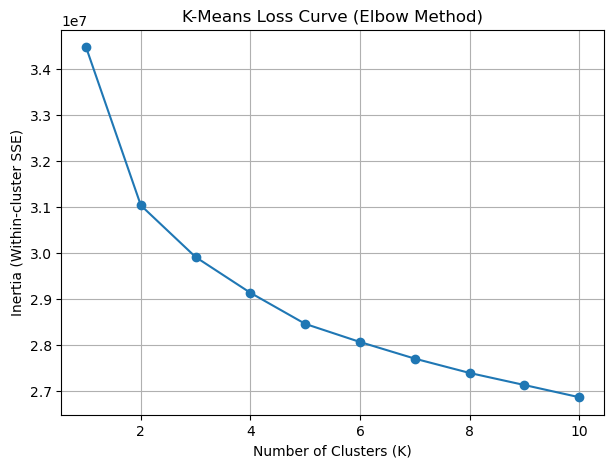

In [27]:
inertia_values = []
K_range = range(1, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_train_pca)
    inertia_values.append(km.inertia_)

plt.figure(figsize=(7,5))
plt.plot(K_range, inertia_values, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-cluster SSE)')
plt.title('K-Means Loss Curve (Elbow Method)')
plt.grid(True)
plt.show()


## K-Means Loss Curve (Elbow Method)

The inertia value is plotted against different numbers of clusters to visualize the K-Means loss curve.

The elbow point indicates an optimal number of clusters, which aligns with the chosen K=5.


## K-Means Evaluation Metrics

The K-Means model is evaluated using:
- Classification accuracy
- Confusion matrix
- Silhouette score
- Inertia (loss)

These metrics assess clustering quality and classification performance.


In [28]:
# Evaluate
print("K-Means Accuracy:", accuracy_score(y_test, y_test_mapped))
print(confusion_matrix(y_test, y_test_mapped))
print(classification_report(y_test, y_test_mapped))

K-Means Accuracy: 0.6617142857142857
[[ 998    3  224  175    0]
 [   0 1255   39  106    0]
 [  12    0 1367   21    0]
 [  17  222  149 1012    0]
 [   2    0 1236  162    0]]
              precision    recall  f1-score   support

           0       0.97      0.71      0.82      1400
           1       0.85      0.90      0.87      1400
           2       0.45      0.98      0.62      1400
           3       0.69      0.72      0.70      1400
           4       0.00      0.00      0.00      1400

    accuracy                           0.66      7000
   macro avg       0.59      0.66      0.60      7000
weighted avg       0.59      0.66      0.60      7000



c:\Users\omara\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\omara\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\omara\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [29]:
silhouette_score(X_train_pca, clusters_train)


np.float64(0.06662795163936149)

In [30]:
# Define Purity Score function
def purity_score(y_true, y_pred):
    """
    Computes purity score for clustering.

    Parameters:
    y_true : array-like of shape (n_samples,)
        True labels
    y_pred : array-like of shape (n_samples,)
        Cluster assignments

    Returns:
    float : purity score between 0 and 1
    """
    contingency_matrix = pd.crosstab(y_true, y_pred)
    return np.sum(np.max(contingency_matrix.values, axis=0)) / np.sum(contingency_matrix.values)

# Predict clusters on test set
clusters_test = kmeans.predict(X_test_pca)

# Map clusters to labels using majority vote
y_test_mapped = map_clusters_to_labels(clusters_test, y_test)

# Compute Purity Score
purity = purity_score(y_test, clusters_test)
print("Purity Score:", purity)


Purity Score: 0.6617142857142857


##Logistic Regression Hyperparameter Tuning with Cross-Validation

## Logistic Regression with Hyperparameter Tuning

Logistic Regression is trained using GridSearchCV with 5-fold cross-validation.  
Different regularization strengths are evaluated to find the optimal model configuration.


In [31]:
# Grid for Logistic Regression
logreg_params = {
    'C': [0.01, 0.1, 1, 10],       # Regularization strength
    'penalty': ['l2'],             # L2 regularization
    'solver': ['lbfgs']            # Solver compatible with multi-class
}

In [32]:
logreg = LogisticRegression(max_iter=300, random_state=42)

grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=logreg_params,
    cv=5,                # 5-fold cross-validation
    scoring='accuracy',  # Evaluate based on accuracy
    n_jobs=-1,
    refit=True
)


In [33]:
grid_search.fit(X_train_pca, y_train)

# Best hyperparameters
print("Best Logistic Regression params:", grid_search.best_params_)


Best Logistic Regression params: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}


## Logistic Regression Evaluation

The final Logistic Regression model is evaluated using:
- Accuracy
- Confusion matrix
- Classification report
- ROC-AUC score

These metrics provide a comprehensive assessment of model performance.


In [34]:
best_logreg = grid_search.best_estimator_

# Predictions on test set
y_pred = best_logreg.predict(X_test_pca)

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=[0,1,2,3,4])
y_pred_prob = best_logreg.predict_proba(X_test_pca)
roc_auc = roc_auc_score(y_test_bin, y_pred_prob, average='macro')
print("Macro ROC AUC:", roc_auc)


Test Accuracy: 0.9114285714285715
Confusion Matrix:
 [[1303    4   45   38   10]
 [   2 1359    0   35    4]
 [  28    3 1218   27  124]
 [  38   24   21 1276   41]
 [   7    5  104   60 1224]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      1400
           1       0.97      0.97      0.97      1400
           2       0.88      0.87      0.87      1400
           3       0.89      0.91      0.90      1400
           4       0.87      0.87      0.87      1400

    accuracy                           0.91      7000
   macro avg       0.91      0.91      0.91      7000
weighted avg       0.91      0.91      0.91      7000

Macro ROC AUC: 0.9900514795918367


## ROC Curve Visualization

The Receiver Operating Characteristic (ROC) curve is plotted using a macro-averaged one-vs-rest approach for multi-class classification.

ROC curves illustrate the trade-off between true positive rate and false positive rate.


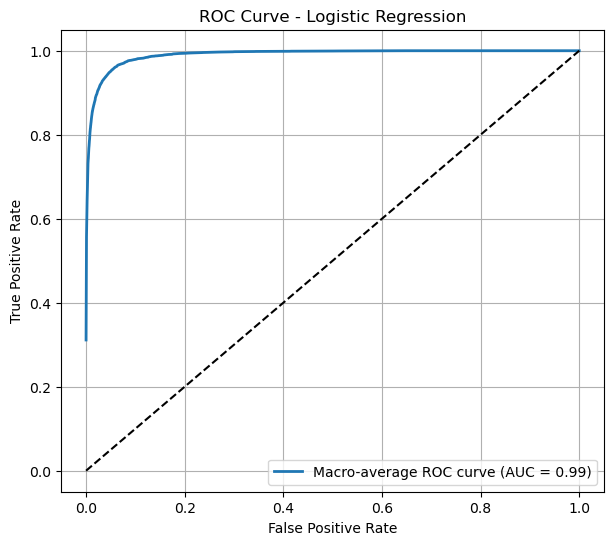

In [35]:
# Binarize labels
y_test_bin = label_binarize(y_test, classes=[0,1,2,3,4])

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(5):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= 5

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot
plt.figure(figsize=(7,6))
plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average ROC curve (AUC = {roc_auc["macro"]:.2f})',
         linewidth=2)

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()